In this cell we get the probabilities graph:

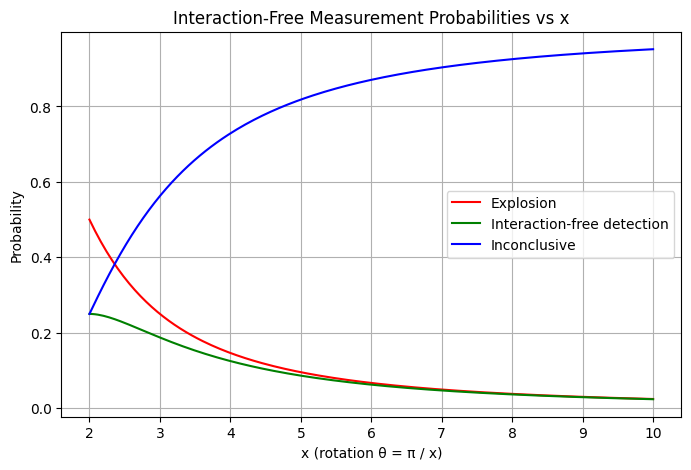

In [73]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(2, 10, 200)
theta = np.pi / x

P_explosion = np.sin(theta/2)**2
P_interaction_free = np.cos(theta/2)**2 * np.sin(theta/2)**2
P_inconclusive = 1 - P_explosion - P_interaction_free

plt.figure(figsize=(8,5))
plt.plot(x, P_explosion, label='Explosion', color='red')
plt.plot(x, P_interaction_free, label='Interaction-free detection', color='green')
plt.plot(x, P_inconclusive, label='Inconclusive', color='blue')
plt.xlabel('x (rotation θ = π / x)')
plt.ylabel('Probability')
plt.title('Interaction-Free Measurement Probabilities vs x')
plt.legend()
plt.grid(True)
plt.show()


In this cell we find the best possible value for the parameter of rotation gates:

Point where Explosion = Inconclusive:
  x ≈ 2.362
  θ = π / x ≈ 1.330 radians
  Explosion       = 38.084%
  Inconclusive     = 38.336%
  Interaction-free = 23.580%


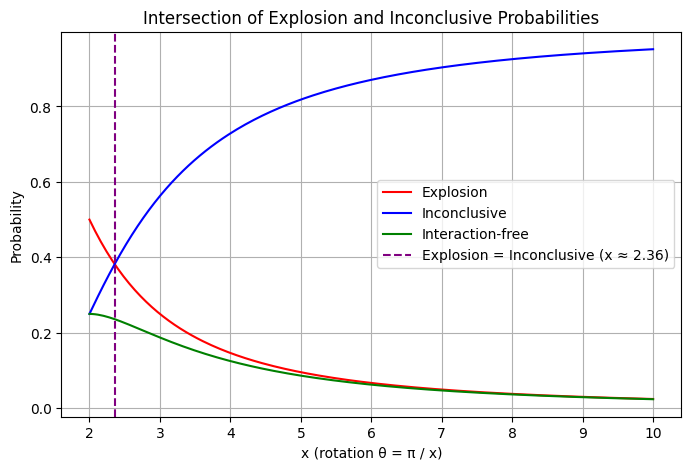

In [74]:
diff = np.abs(P_explosion - P_inconclusive)
best_index_eq = np.argmin(diff)
x_eq = x[best_index_eq]

print(f"Point where Explosion = Inconclusive:")
print(f"  x ≈ {x_eq:.3f}")
print(f"  θ = π / x ≈ {np.pi / x_eq:.3f} radians")
print(f"  Explosion       = {P_explosion[best_index_eq]*100:.3f}%")
print(f"  Inconclusive     = {P_inconclusive[best_index_eq]*100:.3f}%")
print(f"  Interaction-free = {P_interaction_free[best_index_eq]*100:.3f}%")

plt.figure(figsize=(8,5))
plt.plot(x, P_explosion, label='Explosion', color='red')
plt.plot(x, P_inconclusive, label='Inconclusive', color='blue')
plt.plot(x, P_interaction_free, label='Interaction-free', color='green')
plt.axvline(x_eq, color='purple', linestyle='--', label=f'Explosion = Inconclusive (x ≈ {x_eq:.2f})')
plt.xlabel('x (rotation θ = π / x)')
plt.ylabel('Probability')
plt.title('Intersection of Explosion and Inconclusive Probabilities')
plt.legend()
plt.grid(True)
plt.show()

In this cell we make the grid and initialize it with boat cells:

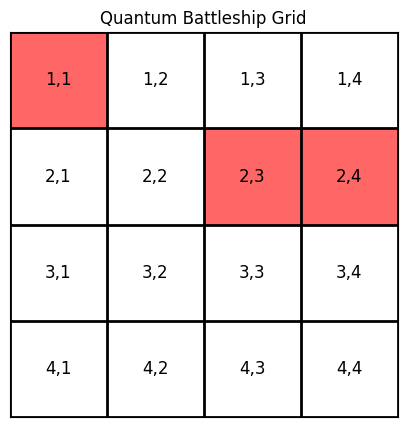

In [75]:
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from numpy import pi
import numpy as np

class QuantumBattleship:
    def __init__(self, N=4, ship_cells=None, theta=None):
        self.N = N
        self.ship_cells = set(ship_cells or [])
        self.theta = theta or pi / 2.362
        self.q_map = {}
        index = 1
        for r in range(1, N+1):
            for c in range(1, N+1):
                self.q_map[(r, c)] = index
                index += 1
        self.n_qubits = N*N + 1

    def plot_grid(self):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_xlim(0, self.N)
        ax.set_ylim(0, self.N)
        for x in range(self.N+1):
            ax.plot([x, x], [0, self.N], color='black', lw=2)
            ax.plot([0, self.N], [x, x], color='black', lw=2)
        for r in range(1, self.N+1):
            for c in range(1, self.N+1):
                label = (r, c)
                if label in self.ship_cells:
                    rect = plt.Rectangle((c-1, self.N-r), 1,1, facecolor='red', alpha=0.6)
                    ax.add_patch(rect)
                ax.text(c-0.5, self.N-r+0.5, f"{r},{c}", ha='center', va='center', fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Quantum Battleship Grid")
        plt.show()

    def line_indices(self, row=None, col=None):
        if row:
            return [self.q_map[(row, c)] for c in range(1, self.N+1)]
        if col:
            return [self.q_map[(r, col)] for r in range(1, self.N+1)]
        return []

    def build_probe(self, row=None, col=None):
        line = self.line_indices(row=row, col=col)
        if not line:
            raise ValueError("Please provide a valid row or column to probe.")

        qreg = QuantumRegister(self.n_qubits, 'q')
        creg = ClassicalRegister(2, 'c')
        qc = QuantumCircuit(qreg, creg)
        probe = 0

        qc.rx(self.theta, qreg[probe])

        for cell in line:
            qc.cx(qreg[probe], qreg[cell])

        qc.rx(-pi, qreg[probe])
        qc.barrier()

        ship_qubits = {self.q_map[pos] for pos in self.ship_cells}

        for cell in line:
            if cell in ship_qubits:
                qc.measure(qreg[cell], creg[1])
                qc.barrier()

        qc.rx(pi, qreg[probe])

        for cell in reversed(line):
            qc.cx(qreg[probe], qreg[cell])

        qc.rx(-self.theta, qreg[probe])
        qc.barrier()
        qc.measure(qreg[probe], creg[0])

        return qc

    def run_probe(self, row=None, col=None, shots=2048):
        qc = self.build_probe(row=row, col=col)
        backend = Aer.get_backend('aer_simulator')
        qc = transpile(qc, backend)
        job = backend.run(qc, shots=shots)
        result = job.result()
        return result.get_counts()


backend = Aer.get_backend('aer_simulator')
ship_cells = [(2,3), (2,4), (1,1)]
qb = QuantumBattleship(N=4, ship_cells=ship_cells)
qb.plot_grid()


In this cell we get the circuit for one single column 3 probe defined here:

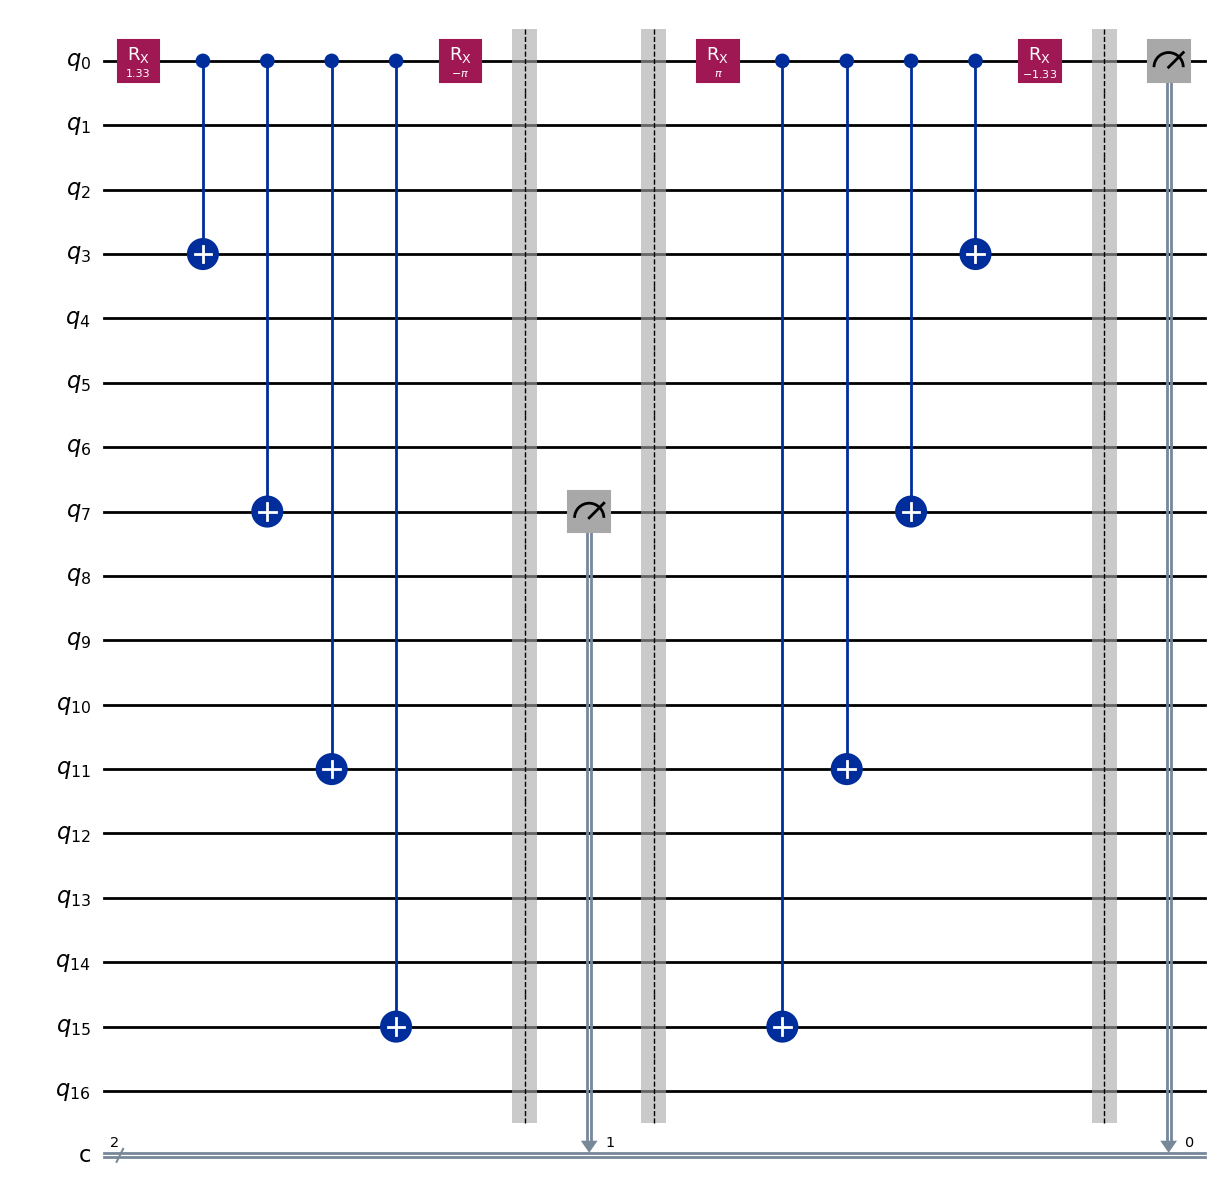

In [76]:
qc_col = qb.build_probe(col=3)
qc_col = transpile(qc_col, backend)

qc_col.draw('mpl')

In this cell we run the probe to get the statistics that match our expectations:

Results for column 3 probe on this grid:
Interaction-free detection probability: 0.2317
Explosion probability: 0.3783
Inconclusive probability: 0.3900
E.V. score (detection/explosion): 0.6125


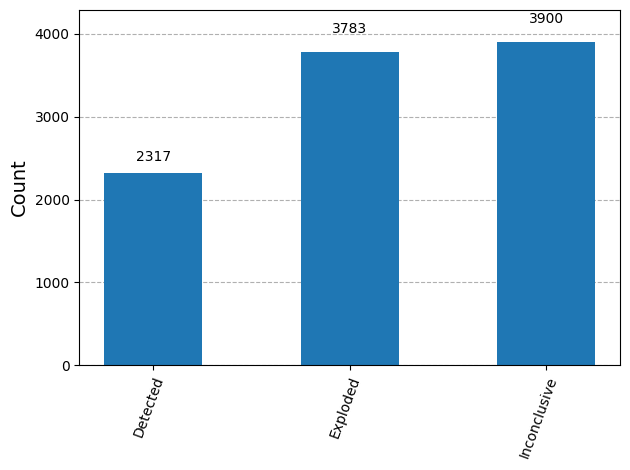

In [77]:
shots = 10000
job = backend.run(qc_col, shots=shots)
result = job.result()
counts = result.get_counts()

detection = 0
explosion = 0
inconclusive = 0

for outcome, count in counts.items():
    probe_meas = outcome[-1]
    bomb_meas = outcome[-2]

    if bomb_meas == '1':
        explosion += count
    elif probe_meas == '1':
        detection += count
    else:
        inconclusive += count

total = shots
detection_prob = detection / total
explosion_prob = explosion / total
inconclusive_prob = inconclusive / total
ev_score = detection_prob / explosion_prob if explosion_prob > 0 else float('inf')

print("Results for column 3 probe on this grid:")
print(f"Interaction-free detection probability: {detection_prob:.4f}")
print(f"Explosion probability: {explosion_prob:.4f}")
print(f"Inconclusive probability: {inconclusive_prob:.4f}")
print(f"E.V. score (detection/explosion): {ev_score:.4f}")

values = {'Detected': counts['01'], 'Exploded': counts['11'] + counts['10'], 'Inconclusive': counts['00']}
plot_histogram(values)


In this cell we get the final battleship game score for the grid:

In [82]:
ev_scores = {}

for r in range(1, qb.N+1):
    qc = qb.build_probe(row=r)
    qc = transpile(qc, backend)
    result = backend.run(qc, shots=shots).result()
    counts = result.get_counts()

    detection = 0
    explosion = 0
    inconclusive = 0
    for outcome, count in counts.items():
        probe_meas = outcome[-1]
        bomb_meas = outcome[-2]
        if bomb_meas == '1':
            explosion += count
        elif probe_meas == '1':
            detection += count
        else:
            inconclusive += count

    detection_prob = detection / shots
    explosion_prob = explosion / shots

    if explosion_prob > 0:
        ev_score = detection_prob / explosion_prob
        ev_scores[f"row_{r}"] = ev_score

for c in range(1, qb.N+1):
    qc = qb.build_probe(col=c)
    qc = transpile(qc, backend)
    result = backend.run(qc, shots=shots).result()
    counts = result.get_counts()

    detection = 0
    explosion = 0
    inconclusive = 0
    for outcome, count in counts.items():
        probe_meas = outcome[-1]
        bomb_meas = outcome[-2]
        if bomb_meas == '1':
            explosion += count
        elif probe_meas == '1':
            detection += count
        else:
            inconclusive += count

    detection_prob = detection / shots
    explosion_prob = explosion / shots

    if explosion_prob > 0:
        ev_score = detection_prob / explosion_prob
        ev_scores[f"col_{c}"] = ev_score

print("Filtered EV scores:", ev_scores)

if ev_scores:
    best_line = max(ev_scores, key=ev_scores.get)
    best_ev = ev_scores[best_line]

    num_probes = 2 * qb.N
    bruteforce_classical = qb.N ** 2
    battleship_score = num_probes / bruteforce_classical

    final_score = best_ev * battleship_score

    print(f"Highest EV score: {best_ev:.4f} ({best_line})")
    print(f"Battleship score factor: {battleship_score:.4f}")
    print(f"Final quantum battleship score: {final_score:.4f}")
else:
    print("No valid EV scores (no boats triggered in any line).")


Filtered EV scores: {'row_1': 0.6022845275181724, 'row_2': 0.6453691275167786, 'col_1': 0.6174183514774495, 'col_3': 0.6216993464052287, 'col_4': 0.6155253528489284}
Highest EV score: 0.6454 (row_2)
Battleship score factor: 0.5000
Final quantum battleship score: 0.3227
